In [6]:
# Clustering of timeseries data
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from VisualizationFunctions import plot_by_factor, AnalyzeClusters
%matplotlib inline

In [2]:
print('Reading in the data...')
agg = pd.read_csv('sku_labels.csv')
df = pd.read_csv('extracted_features.csv')
df.dropna(axis=1, inplace=True)

scale = MinMaxScaler()
skus = df['id']
df.set_index('id', inplace=True)
X = scale.fit_transform(df)
names = df.columns

Reading in the data...


In [3]:
print('Running Dimentionality Reduction...')
dimred = TSNE(2)
tsnes = dimred.fit_transform(X)

#Merge tsne coordinates onto original df with sku_keys
plot_df = pd.DataFrame(tsnes).join(df.reset_index())

#Merge above tsne and features table to sku_key and categories
plot_df['sku_key'] = plot_df['id'].astype(int)
agg['sku_key'] = agg['sku_key'].astype(int)
plot_df = plot_df.merge(agg, how='left', on='sku_key')

colors=['b', 'r', 'g', 'y', 'm', 'orange', 'gold', 'skyblue']

Running Dimentionality Reduction...


In [4]:
plot_df.head()

,0,1,id,sales__abs_energy,sales__absolute_sum_of_changes,"sales__agg_autocorrelation__f_agg_""mean""","sales__agg_autocorrelation__f_agg_""median""","sales__agg_autocorrelation__f_agg_""var""","sales__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","sales__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""",...,sales__value_count__value_1,sales__value_count__value_inf,sales__value_count__value_nan,sales__variance,sales__variance_larger_than_standard_deviation,sku_key,sku_department,sku_subdepartment,sku_category,sku_subcategory
0,-27.702900,-3.215469,28,455.0,228.0,0.009909,-0.001607,0.001339,0.188732,0.359772,...,25.0,0.0,0.0,0.621100,0.0,28,TY,06,063,20G
1,-14.912357,-10.794986,34,186.0,226.0,-0.004615,-0.017574,0.001181,1.335614,-0.138257,...,78.0,0.0,0.0,0.236220,0.0,34,TY,4,11,35A
2,19.818968,51.615055,100,6946.0,1549.0,0.009112,0.010989,0.001624,7.239437,-0.195348,...,157.0,0.0,0.0,5.145510,1.0,100,BH,02,38,C09
3,-10.551961,-51.798206,152,78.0,85.0,-0.002430,-0.012023,0.001742,0.699379,-0.093300,...,16.0,0.0,0.0,0.109897,0.0,152,BH,02,139,00L
4,-1.562003,35.144501,182,4038.0,1163.0,-0.005931,-0.003367,0.001556,3.848592,0.159739,...,135.0,0.0,0.0,4.060313,1.0,182,TY,8,33,16K


/home/andries/Project-Echo_edsa/clustering/VisualizationFunctions.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda

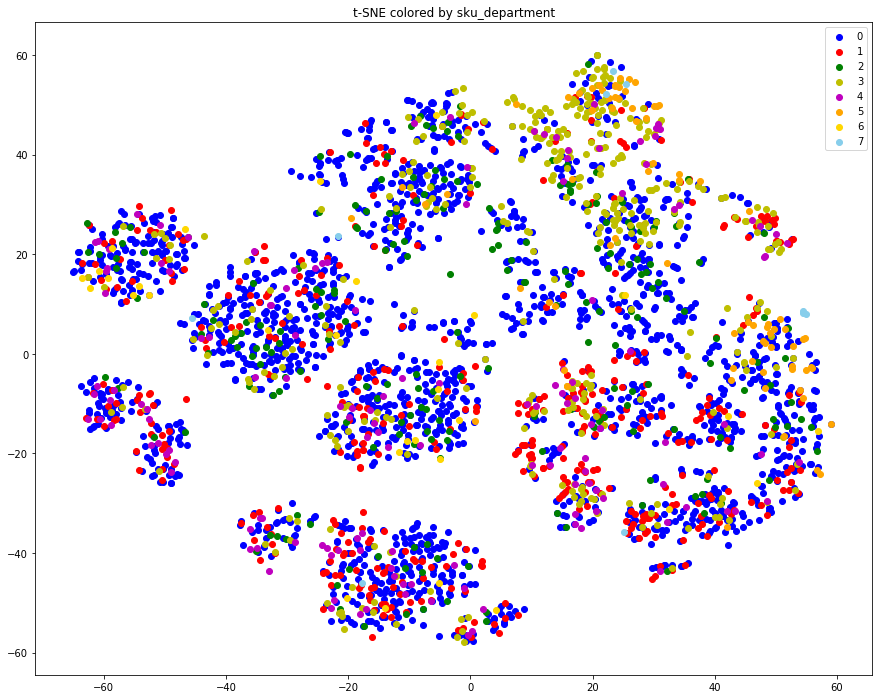

In [7]:
plot_by_factor(plot_df, 'sku_department', colors, showplot=True)

In [20]:
colors = ['darkblue', 'tomato', 'orchid', 'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r', 'brown']
run_cont = ['sales', 'selling_price', 'avg_discount']
run_cats = ['sku_department', 'sku_subdepartment', 'sku_category', 'sku_subcategory']

product_sales = pd.read_csv('aggregate_products.csv')
som_clus = pd.read_csv('som_clusters.csv')
som_clus.columns = ['sku_key', 'cluster']

analyze_som = AnalyzeClusters()
df_dict = analyze_som.make_dataset(product_sales, som_clus)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


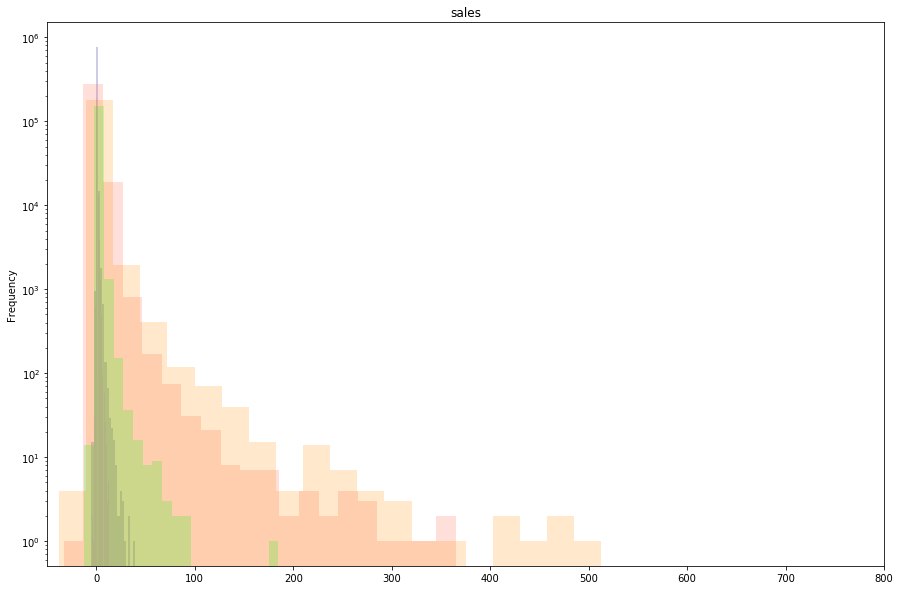

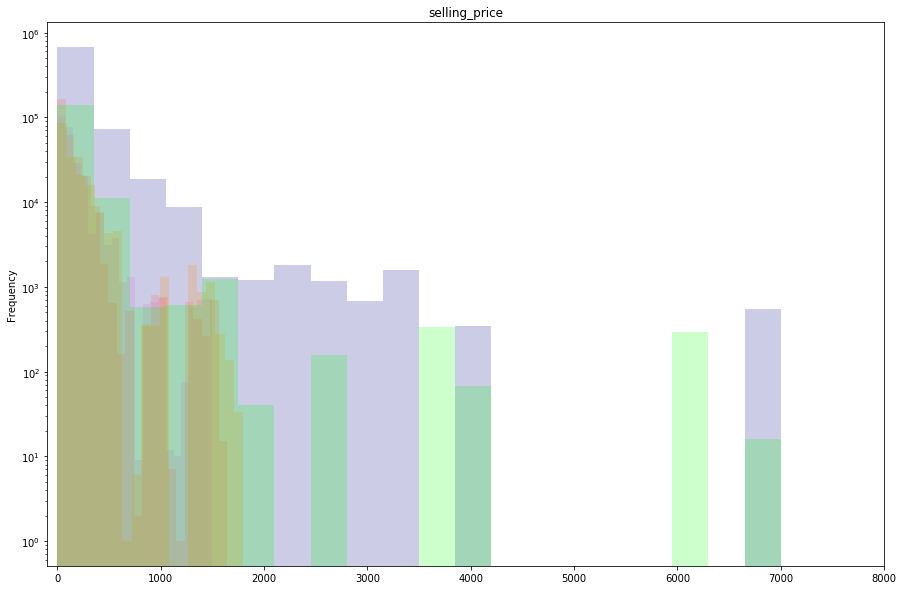

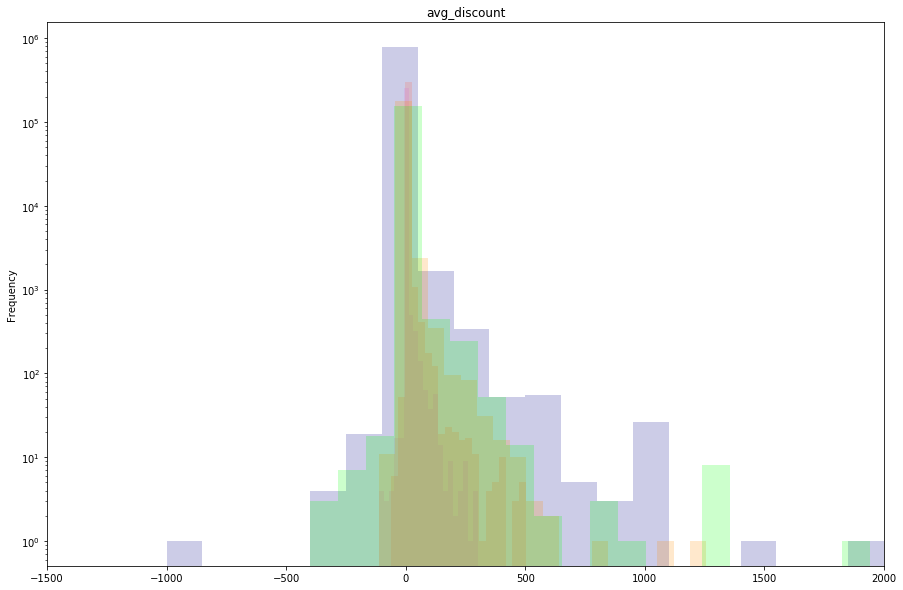

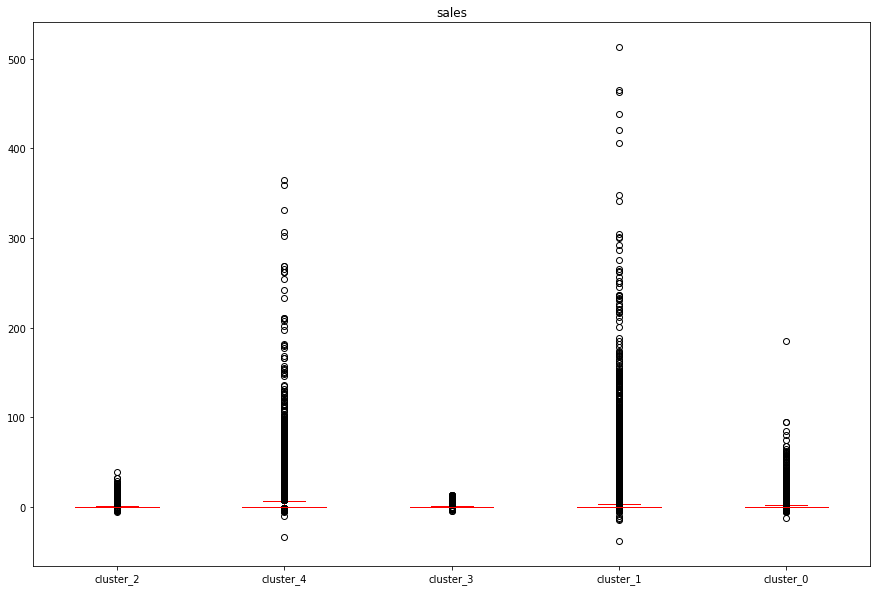

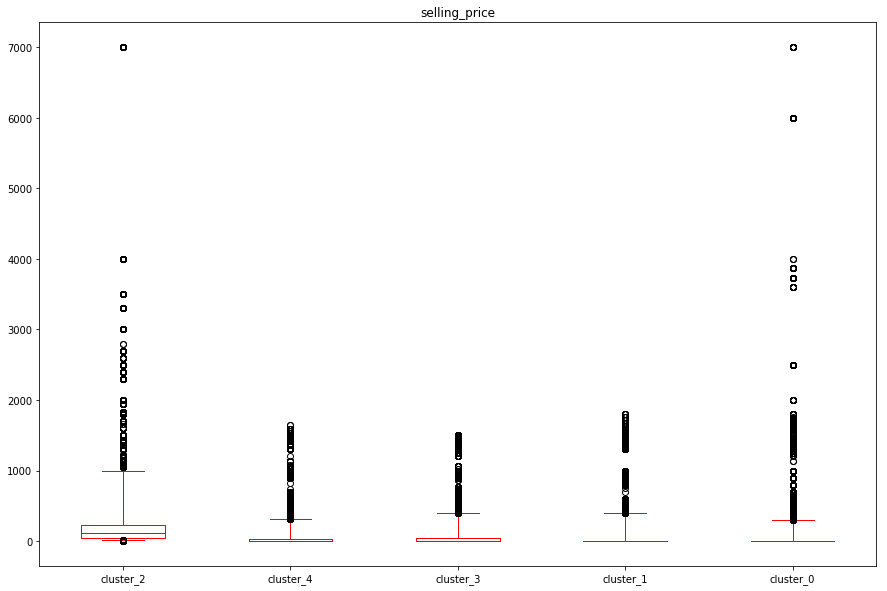

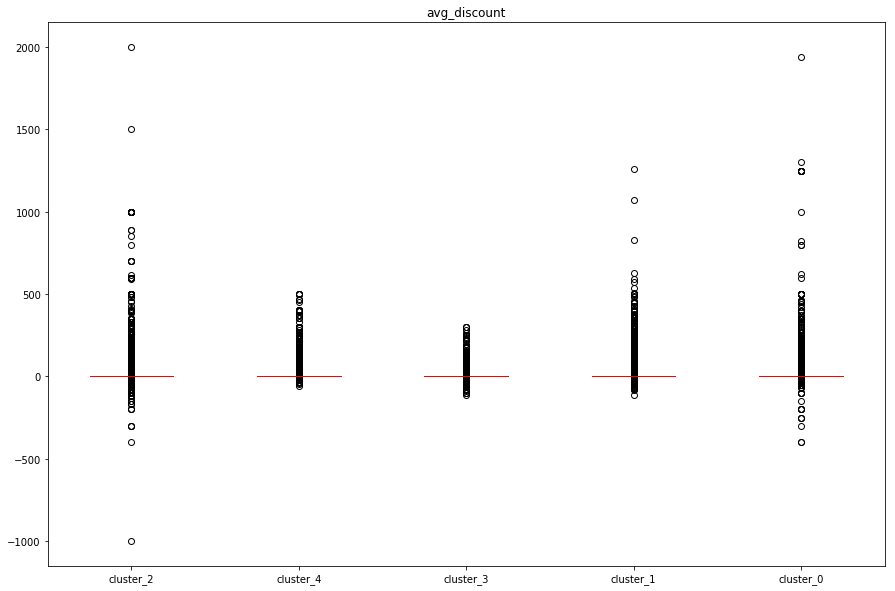

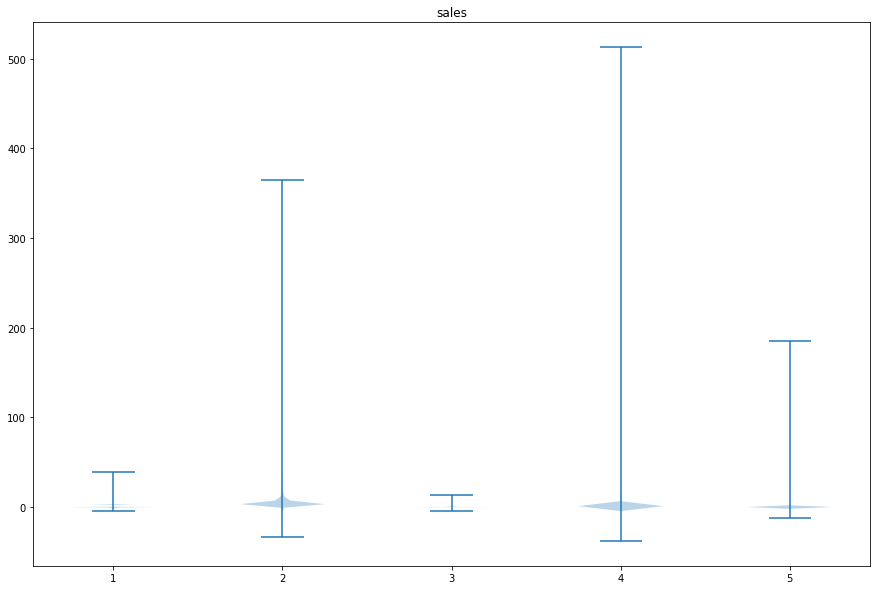

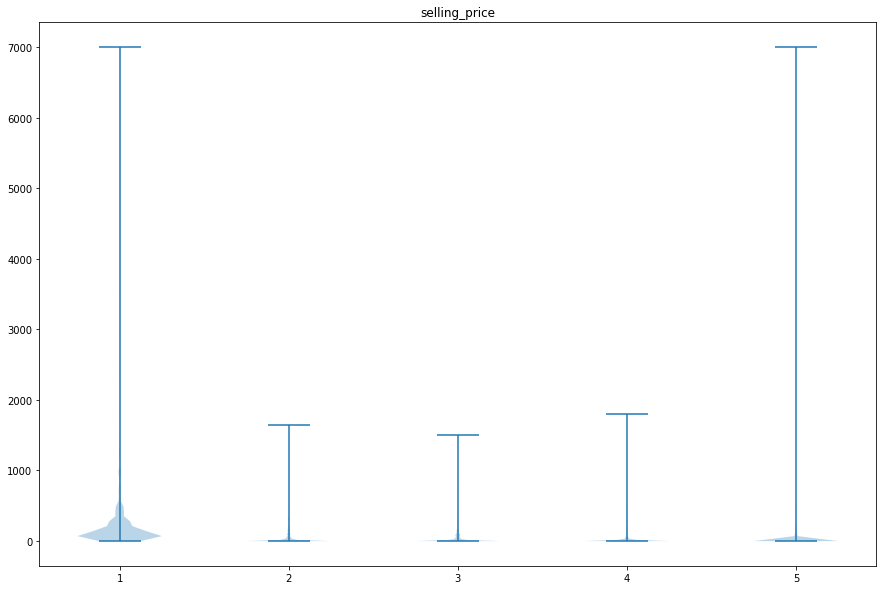

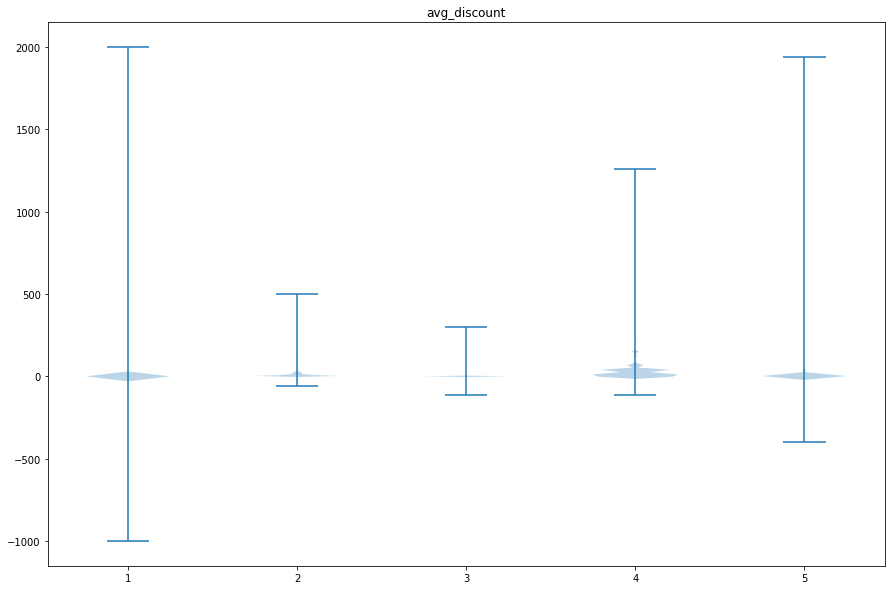



 sku_department


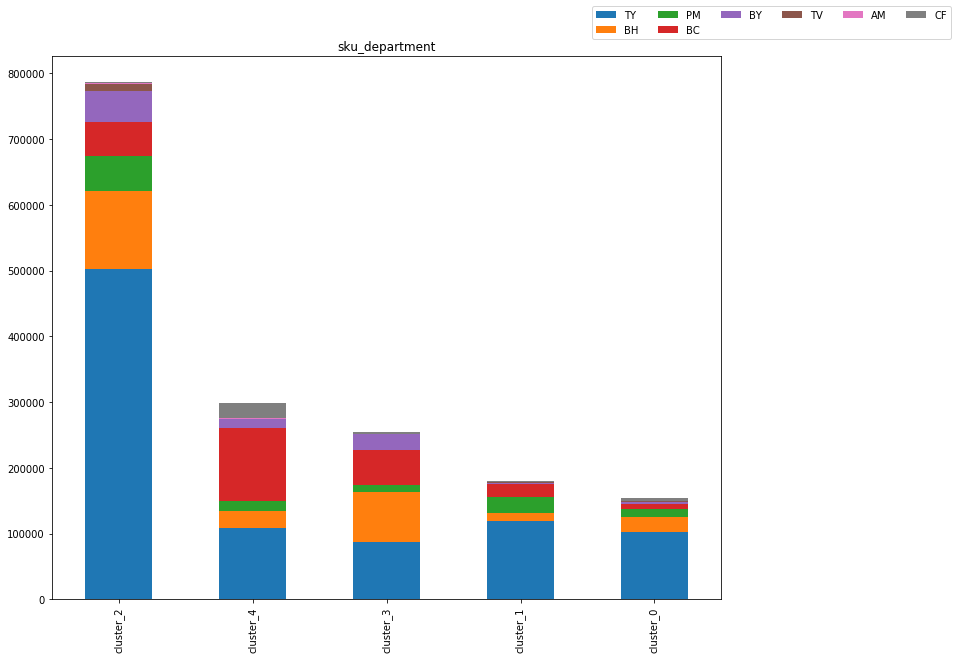



 sku_subdepartment


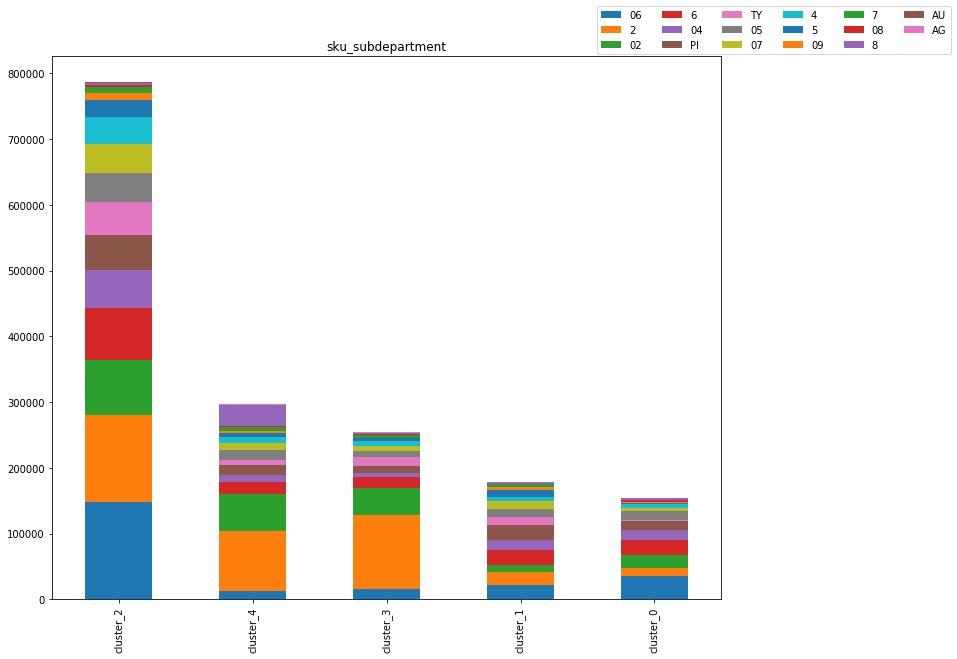



 sku_category


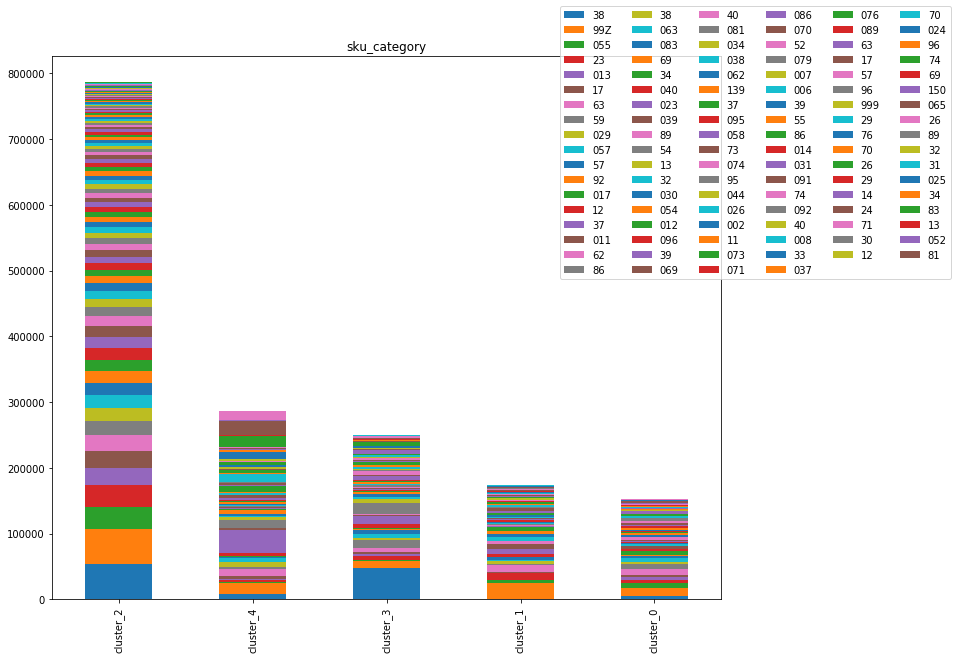



 sku_subcategory


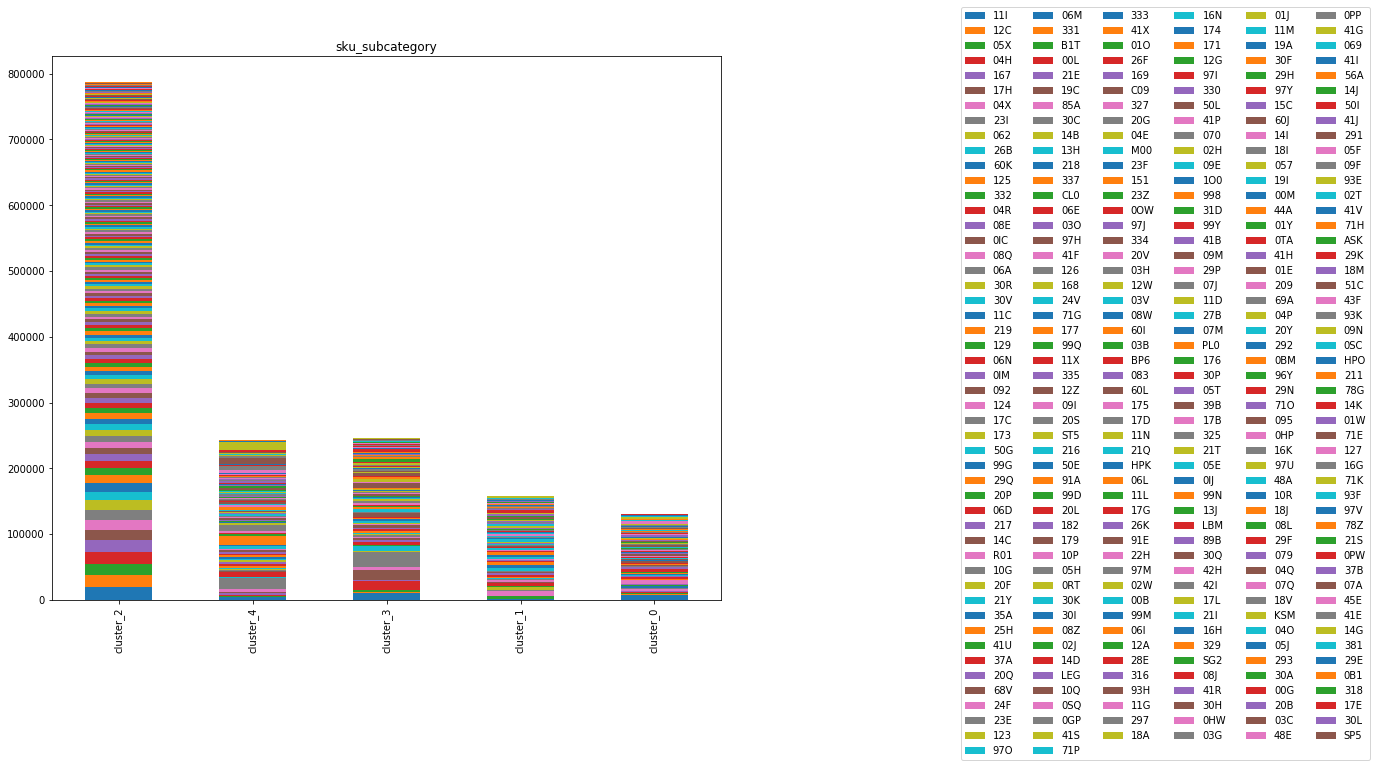

In [21]:
analyze_som.plot_cluster_continuous(df_dict, run_cont, colors, True)
analyze_som.plot_cluster_continuous_box(df_dict, run_cont, True)
analyze_som.plot_cluster_continuous_violin(df_dict, run_cont, True)
analyze_som.plot_cluster_categorical(df_dict, run_cats, True)

/home/andries/Project-Echo_edsa/clustering/VisualizationFunctions.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda

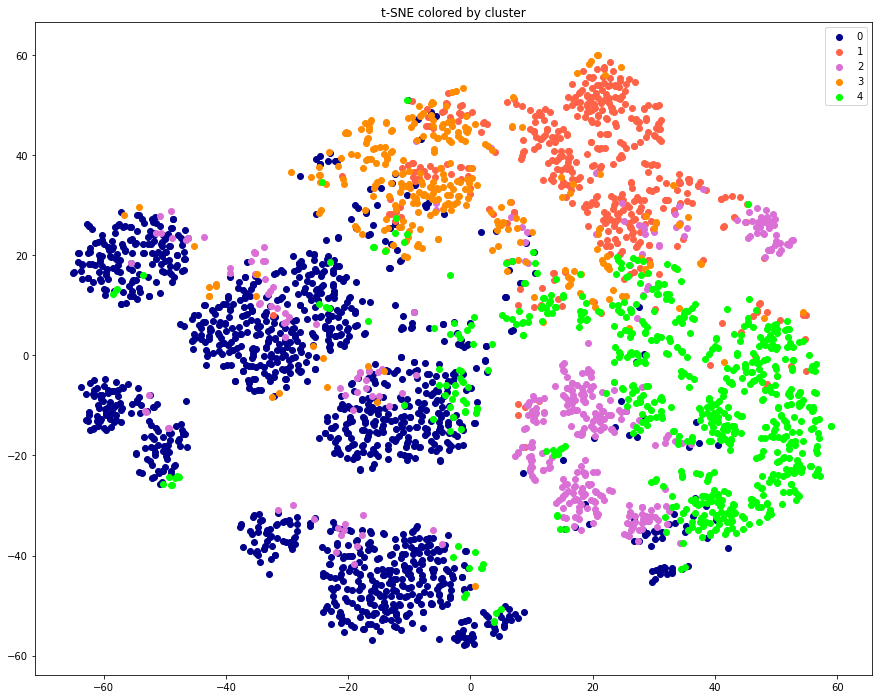

In [26]:
som_tsne = plot_df.merge(som_clus, left_on='id', right_on='sku_key')

plot_by_factor(som_tsne, 'cluster', colors, True)

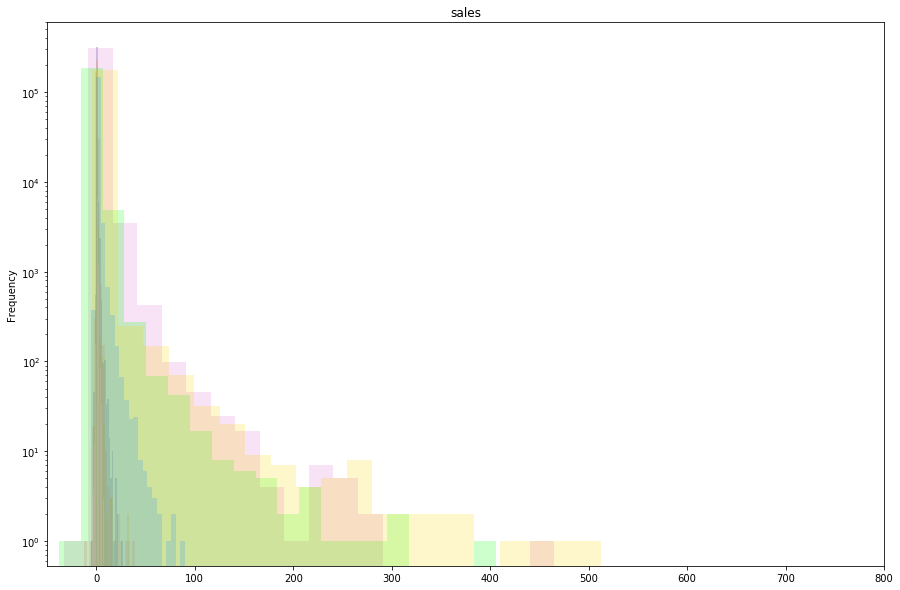

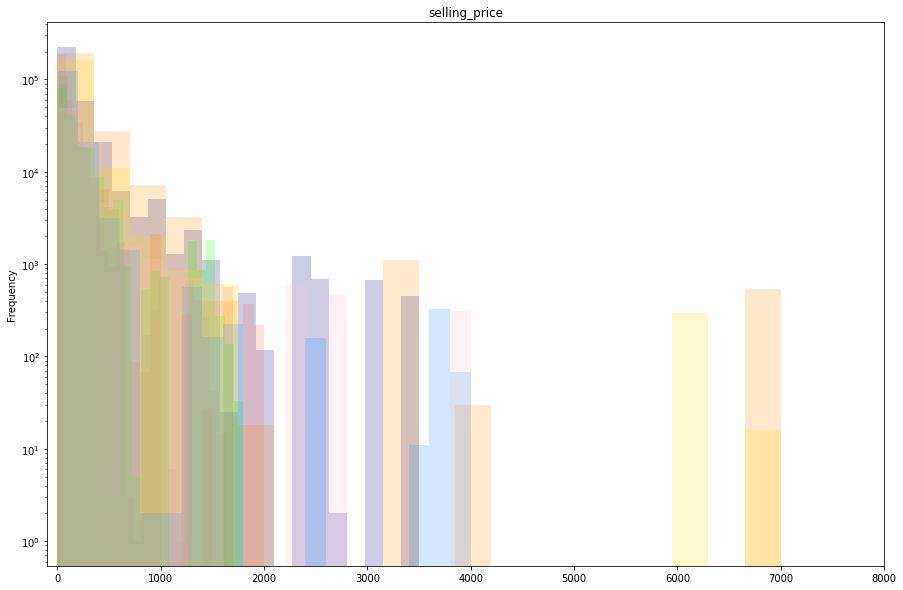

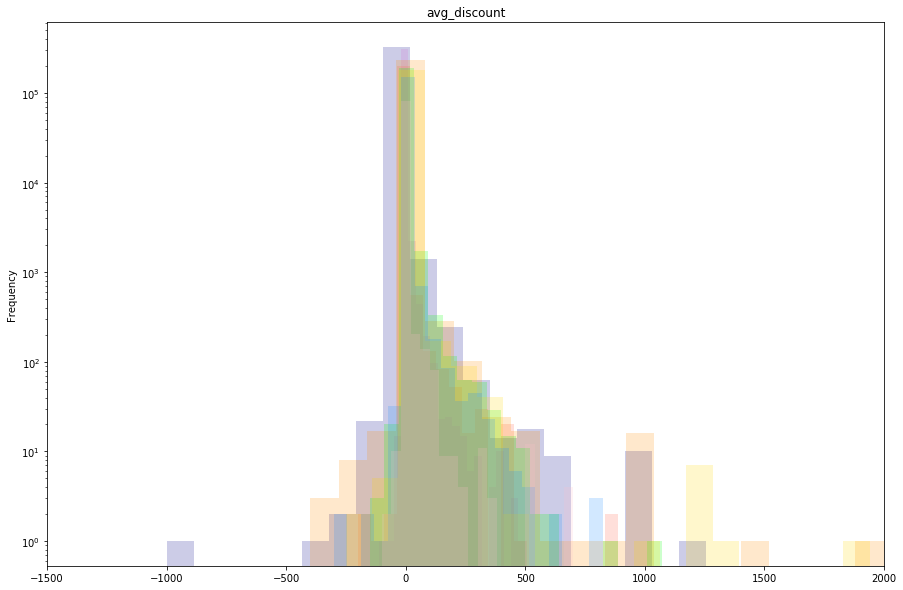

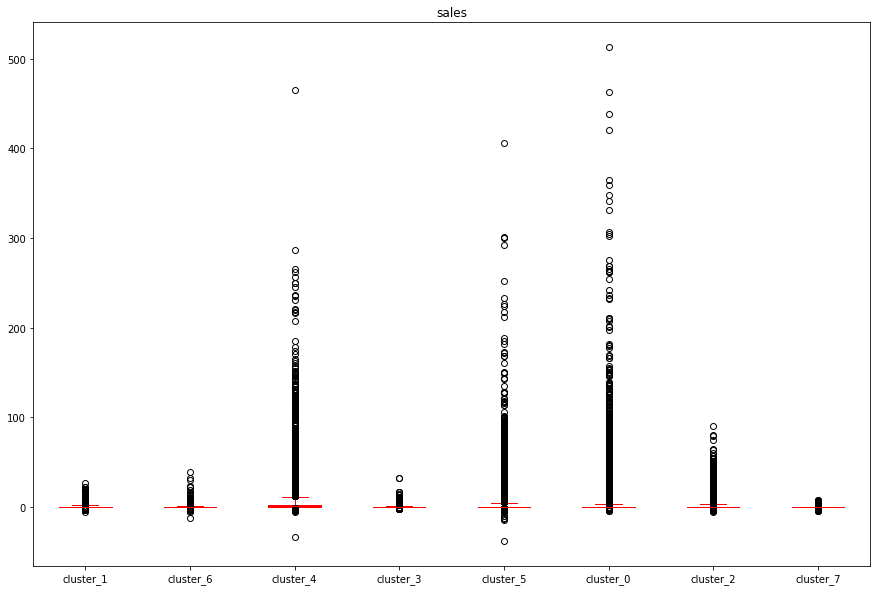

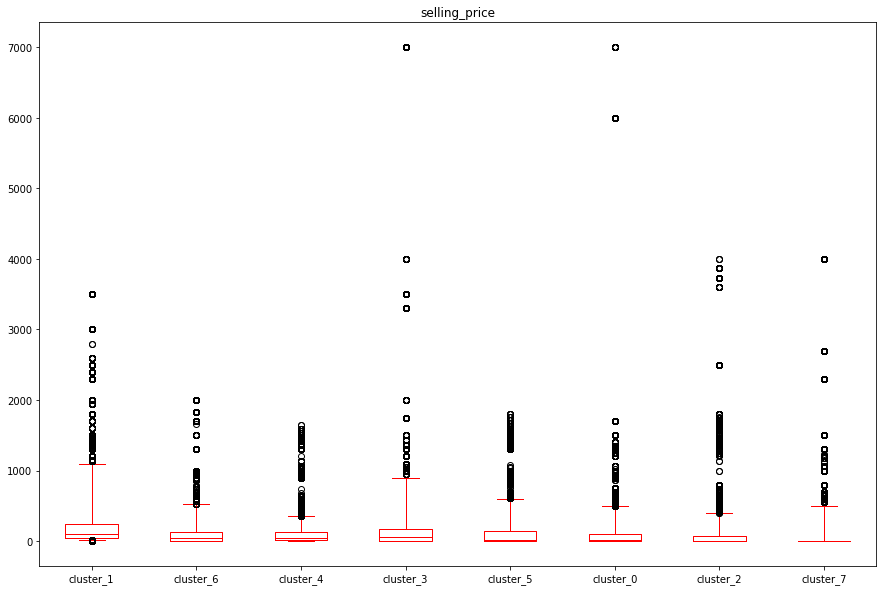

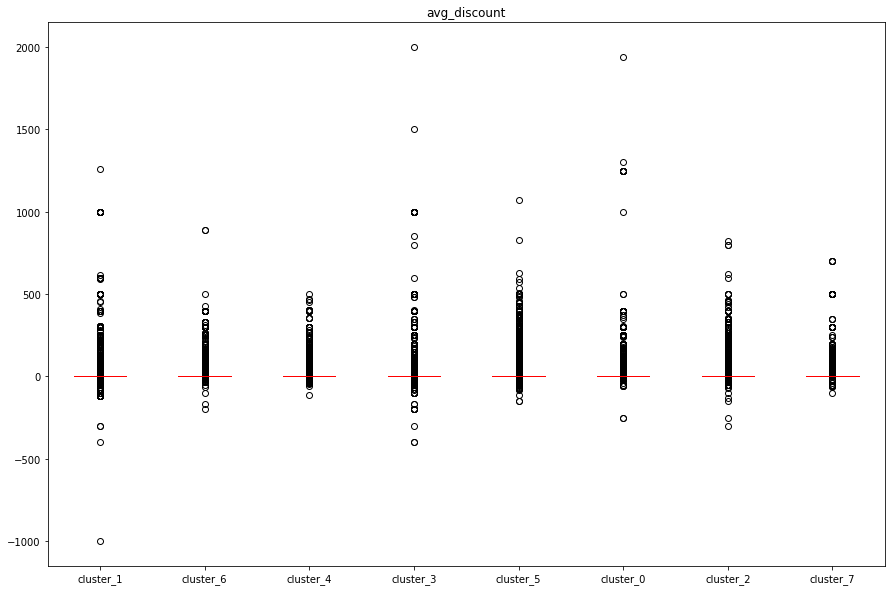

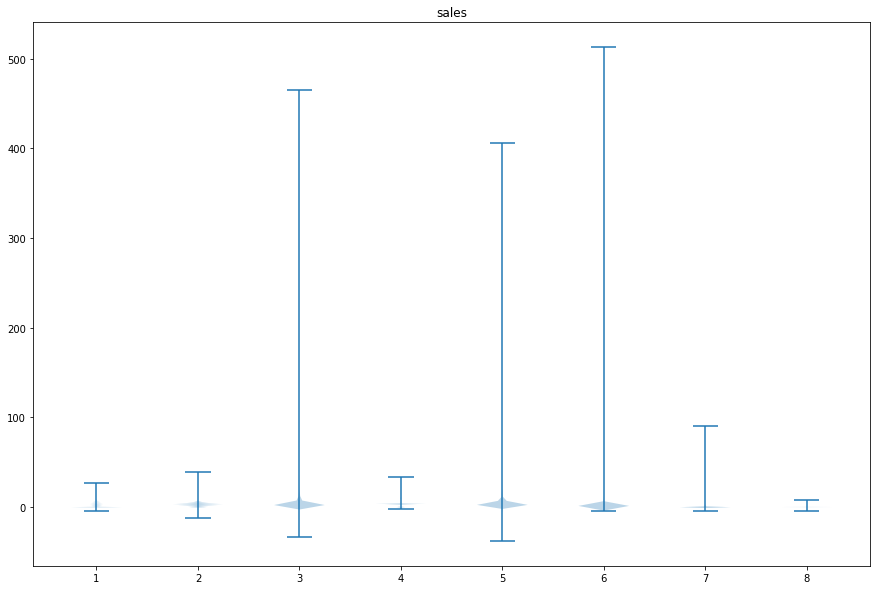

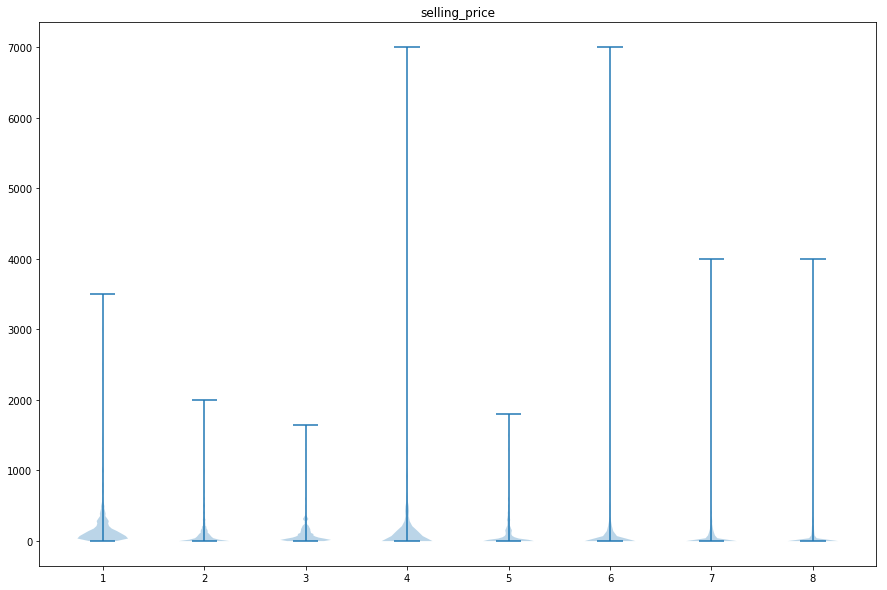

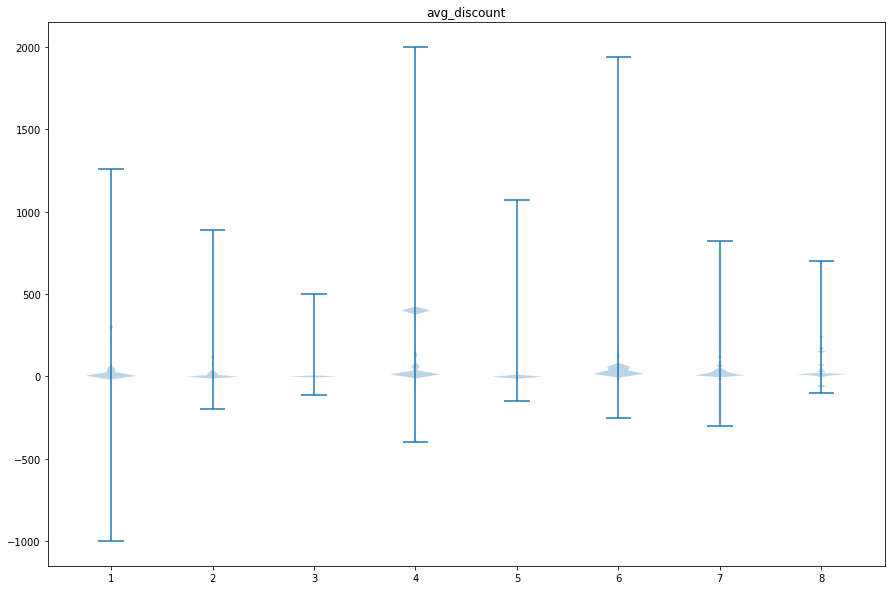



 sku_department


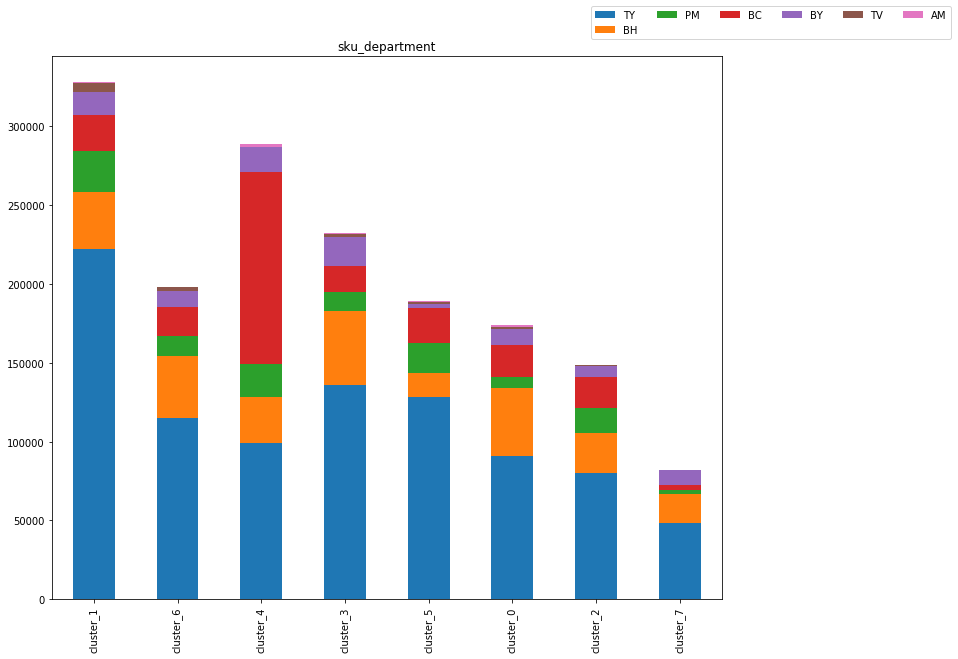



 sku_subdepartment


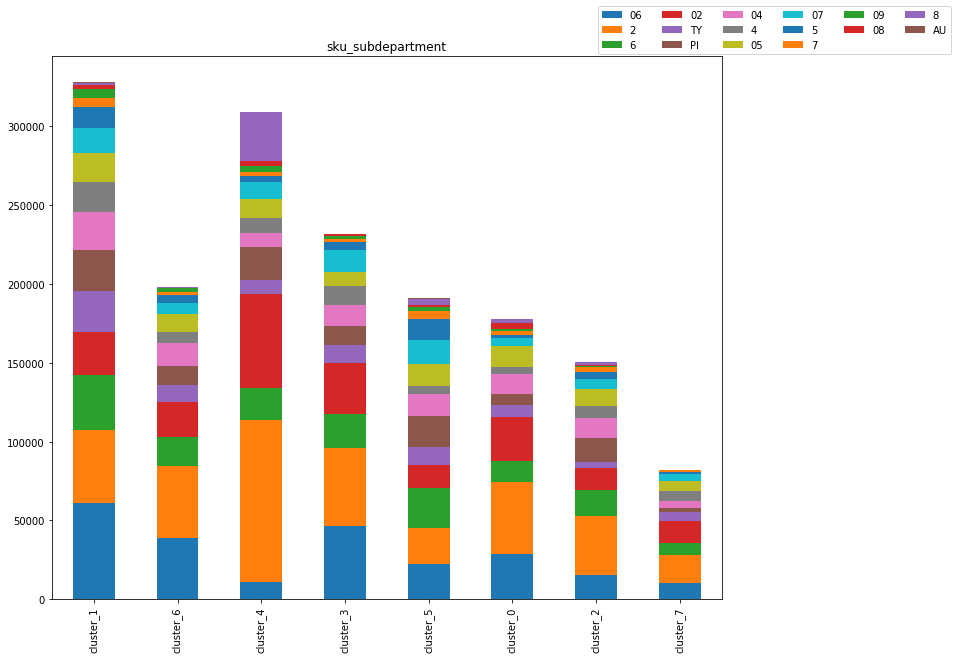



 sku_category


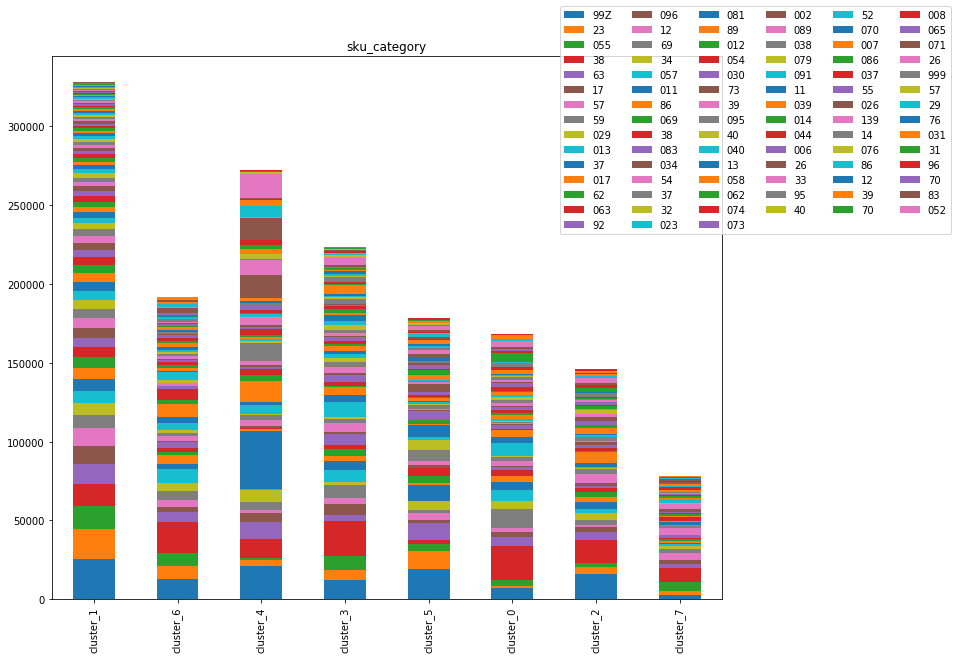



 sku_subcategory


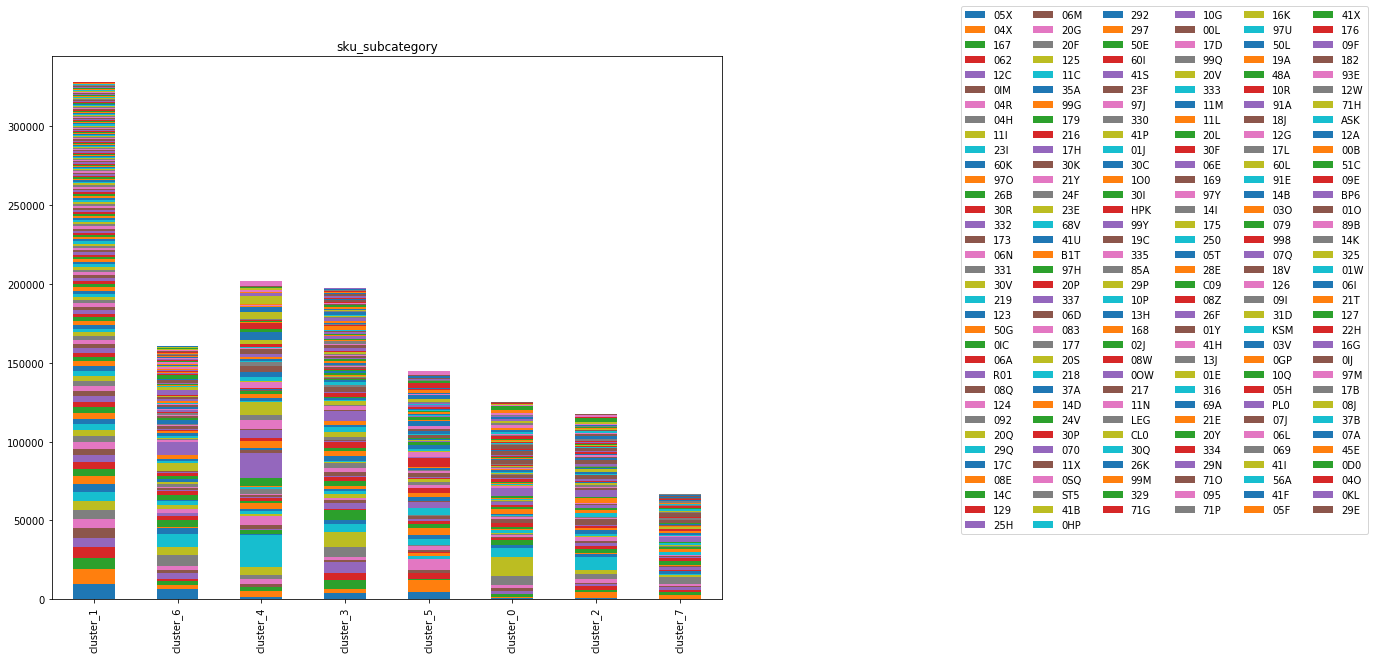

In [28]:
tsne_clus = pd.read_csv('tsne_clusters.csv')
tsne_clus.columns = ['sku_key', 'cluster']

analyze_tsne = AnalyzeClusters()
df_dict = analyze_tsne.make_dataset(product_sales, tsne_clus)

analyze_tsne.plot_cluster_continuous(df_dict, run_cont, colors, True)
analyze_tsne.plot_cluster_continuous_box(df_dict, run_cont, True)
analyze_tsne.plot_cluster_continuous_violin(df_dict, run_cont, True)
analyze_tsne.plot_cluster_categorical(df_dict, run_cats, True)

/home/andries/Project-Echo_edsa/clustering/VisualizationFunctions.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda

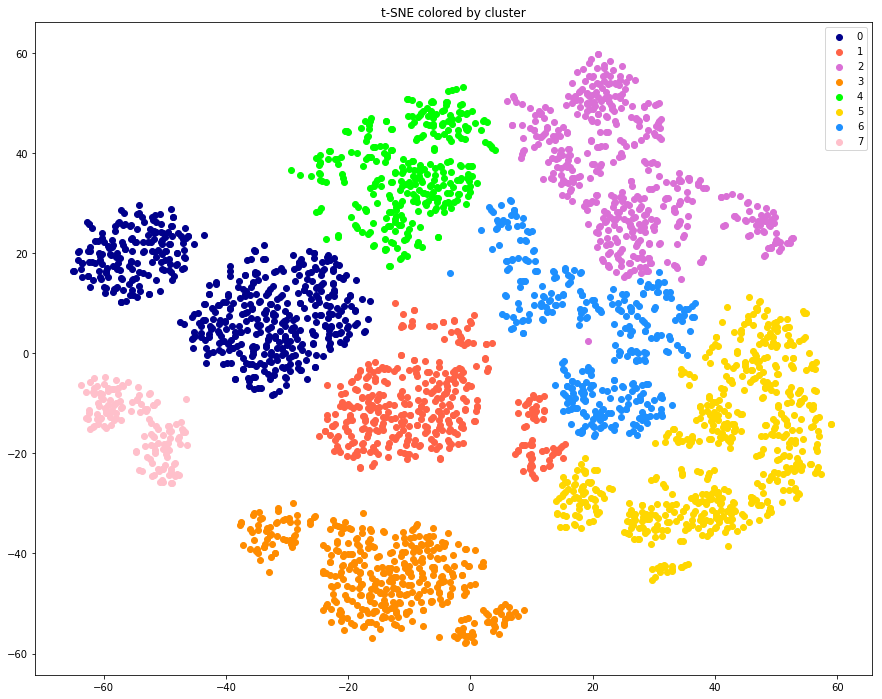

In [30]:
tsne_tsne = plot_df.merge(tsne_clus, left_on='id', right_on='sku_key')

plot_by_factor(tsne_tsne, 'cluster', colors, True)

In [31]:
clusters_dtw = pd.read_csv('dtw_clusters.csv')
clusters_dtw.columns = ['sku_key', 'cluster']

analyze_dtw = AnalyzeClusters()
df_dict = analyze_dtw.make_dataset(product_sales, clusters_dtw)

In [35]:
colors = ['darkblue', 'blue', 'skyblue', 'tomato', 'orchid',
          'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r',
          'brown', 'black', 'yellow', 'red', 'b',
         'darkblue', 'blue', 'skyblue', 'tomato', 'orchid',
          'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r',
          'brown', 'black', 'yellow', 'red', 'b',
         'darkblue', 'blue', 'skyblue', 'tomato', 'orchid',
          'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r',
          'brown', 'black', 'yellow', 'red', 'b',
         'darkblue', 'blue', 'skyblue', 'tomato', 'orchid',
          'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r',
          'brown', 'black', 'yellow', 'red', 'b',
         'darkblue', 'blue', 'skyblue', 'tomato', 'orchid',
          'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r',
          'brown', 'black', 'yellow', 'red', 'b',
         'darkblue', 'blue', 'skyblue', 'tomato', 'orchid',
          'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r',
          'brown', 'black', 'yellow', 'red', 'b',
         'darkblue', 'blue', 'skyblue', 'tomato', 'orchid',
          'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r',
          'brown', 'black', 'yellow', 'red', 'b',
         'darkblue', 'blue', 'skyblue', 'tomato', 'orchid',
          'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r',
          'brown', 'black', 'yellow', 'red', 'b',
         'darkblue', 'blue', 'skyblue', 'tomato', 'orchid',
          'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r',
          'brown', 'black', 'yellow', 'red', 'b',
         'darkblue', 'blue', 'skyblue', 'tomato', 'orchid',
          'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r',
          'brown', 'black', 'yellow', 'red', 'b',]

/home/andries/Project-Echo_edsa/clustering/VisualizationFunctions.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda

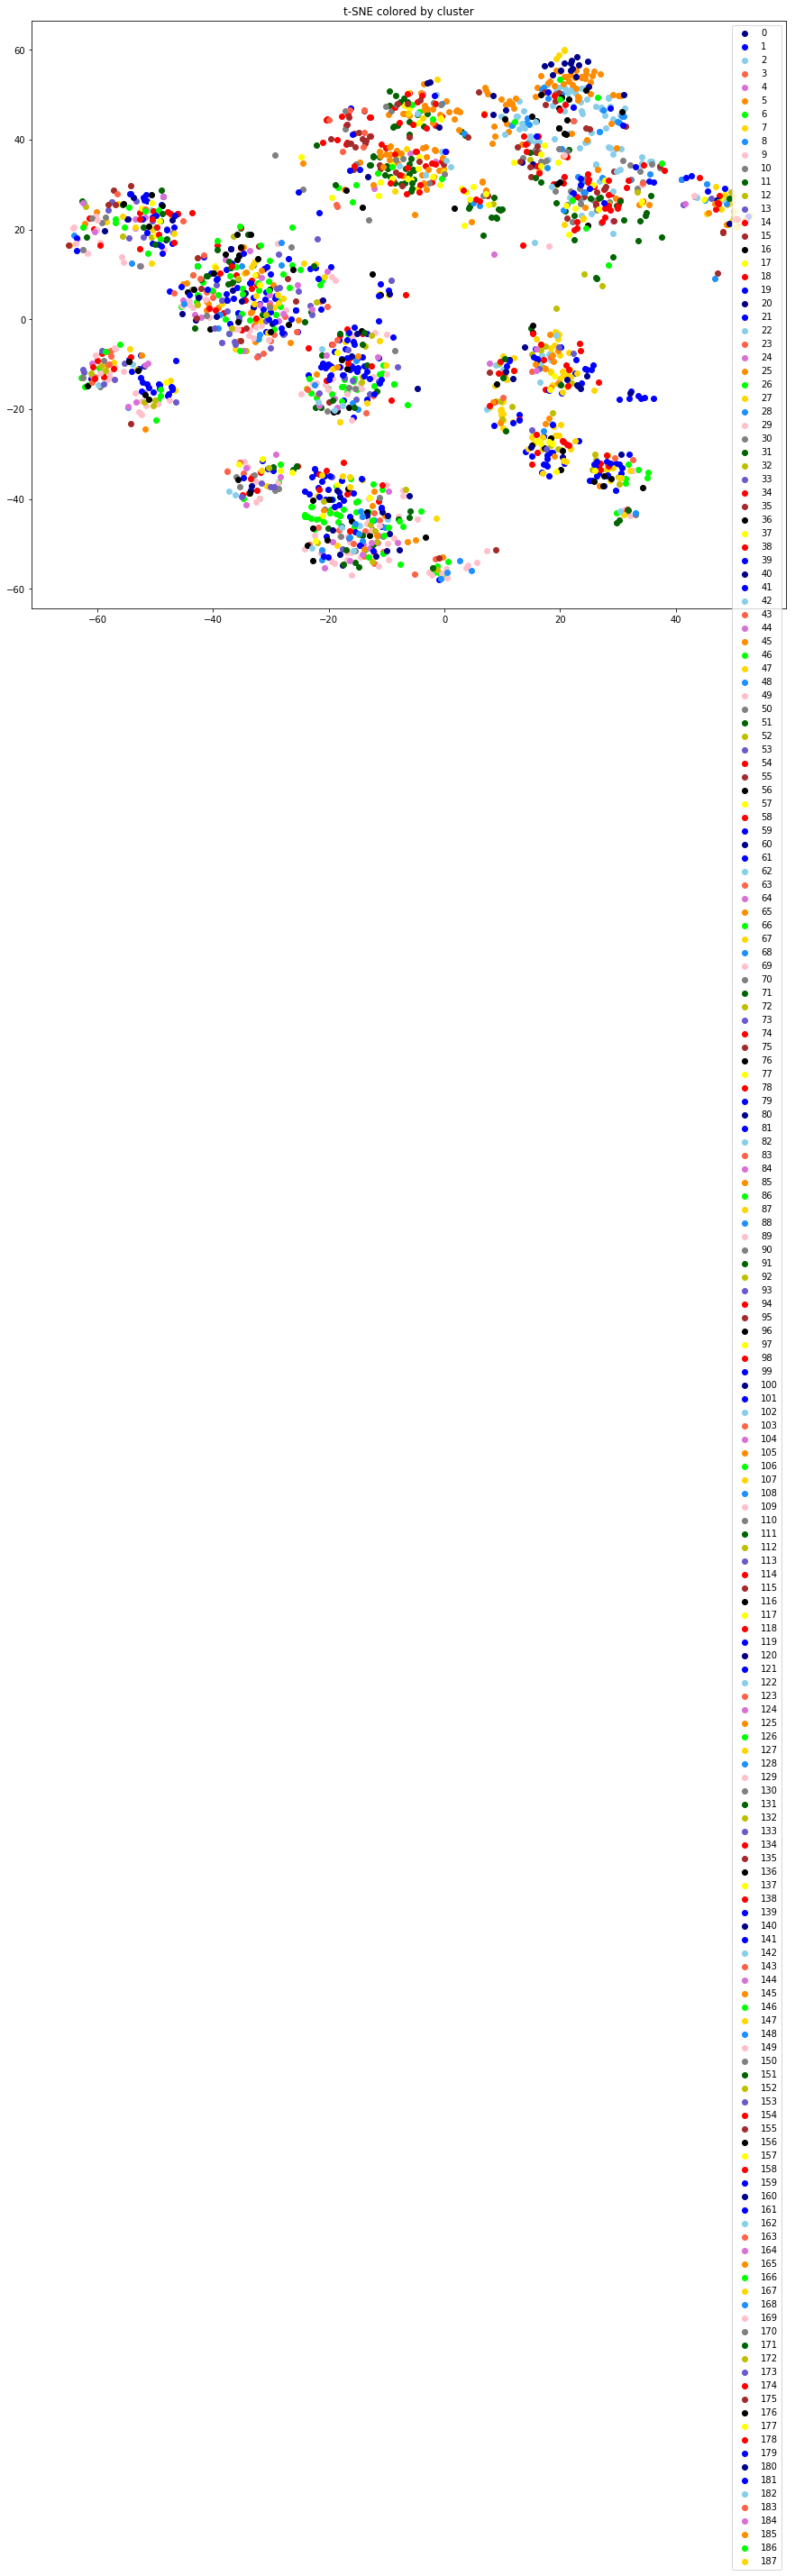

In [36]:
dtw_tsne = plot_df.merge(clusters_dtw, left_on='id', right_on='sku_key')

plot_by_factor(dtw_tsne, 'cluster', colors, True)

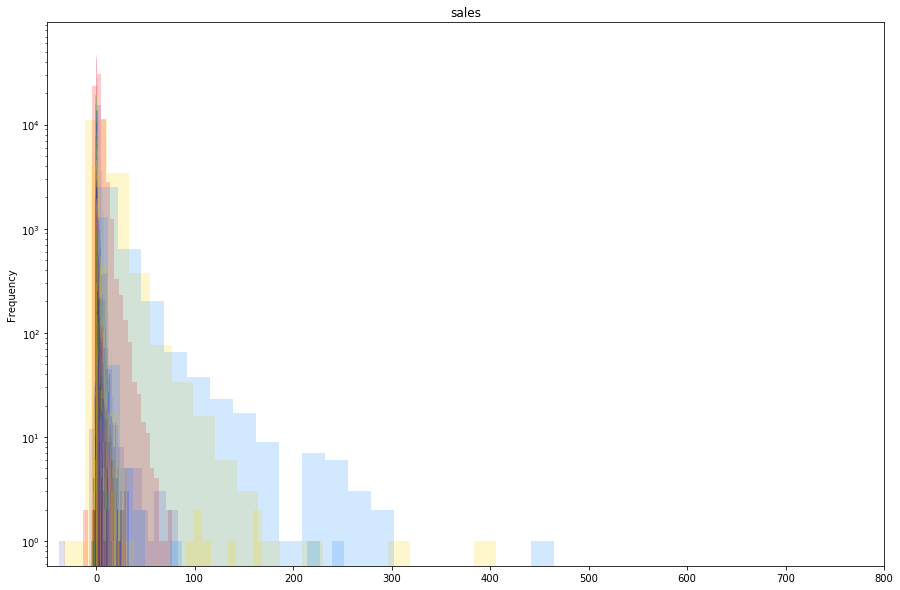

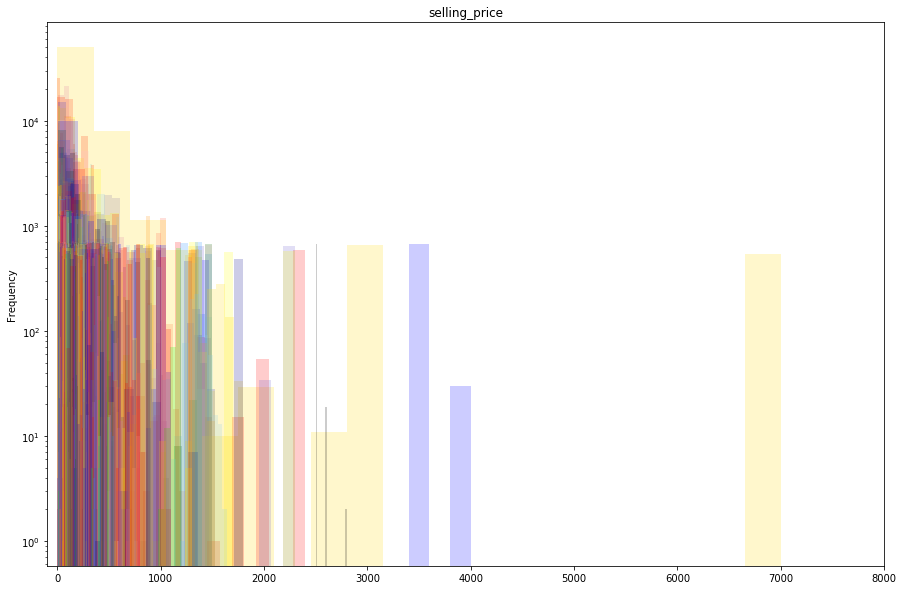

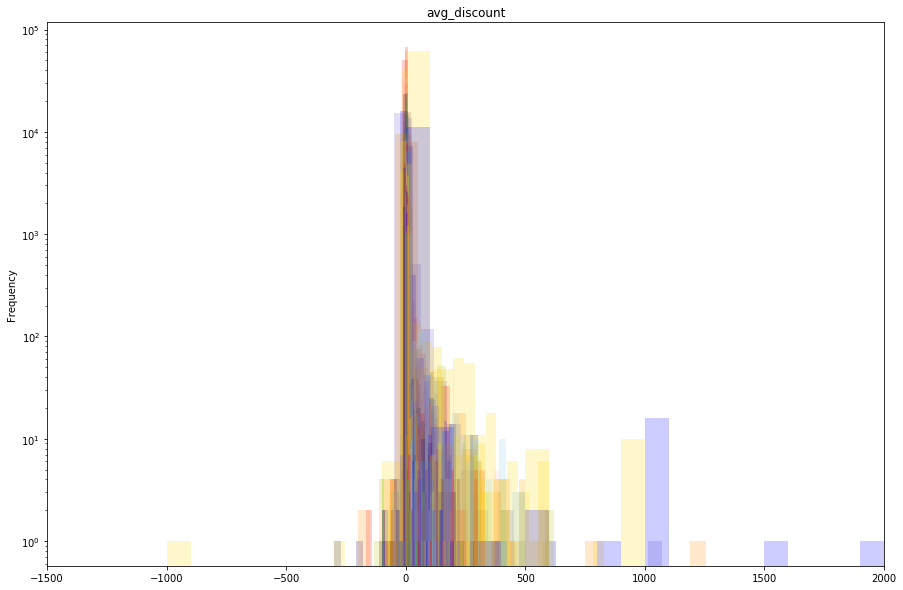

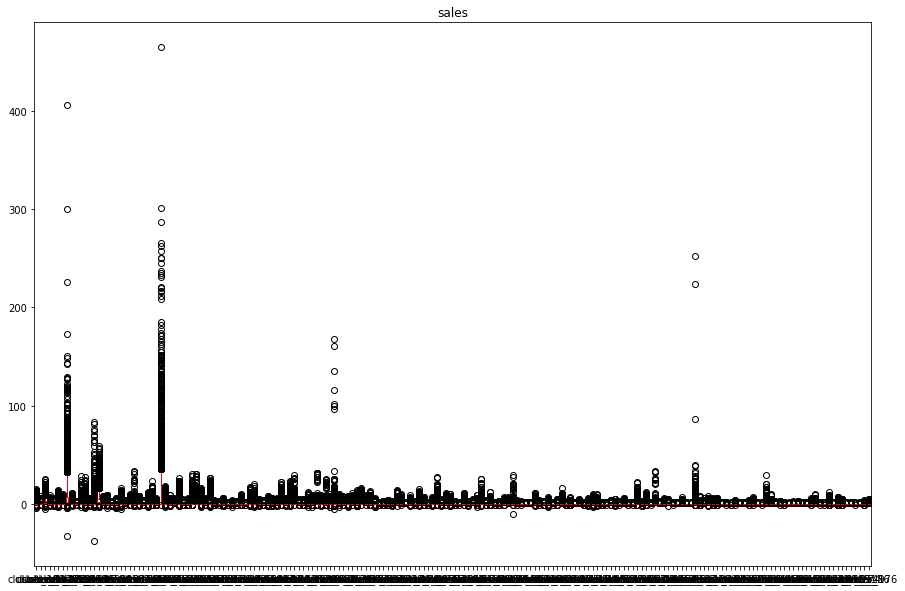

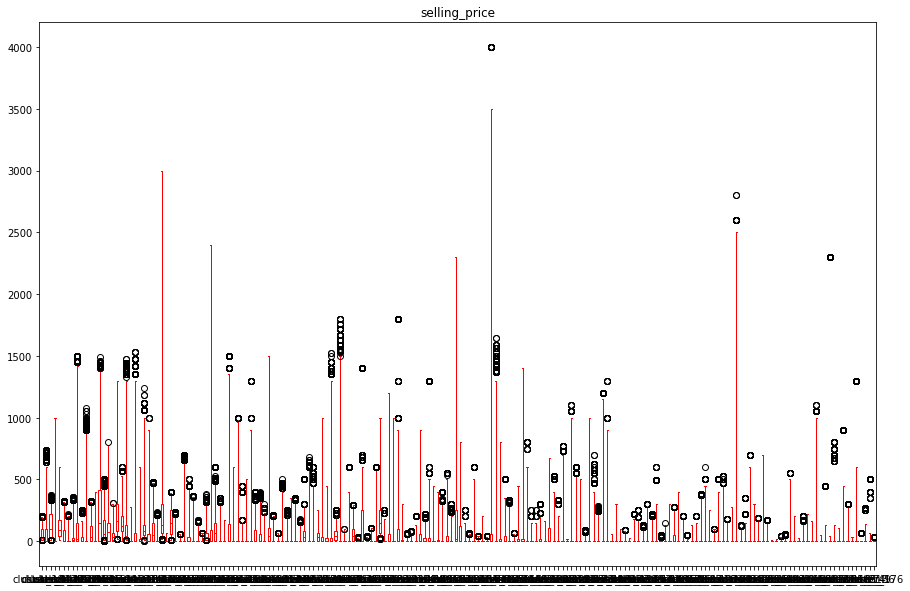

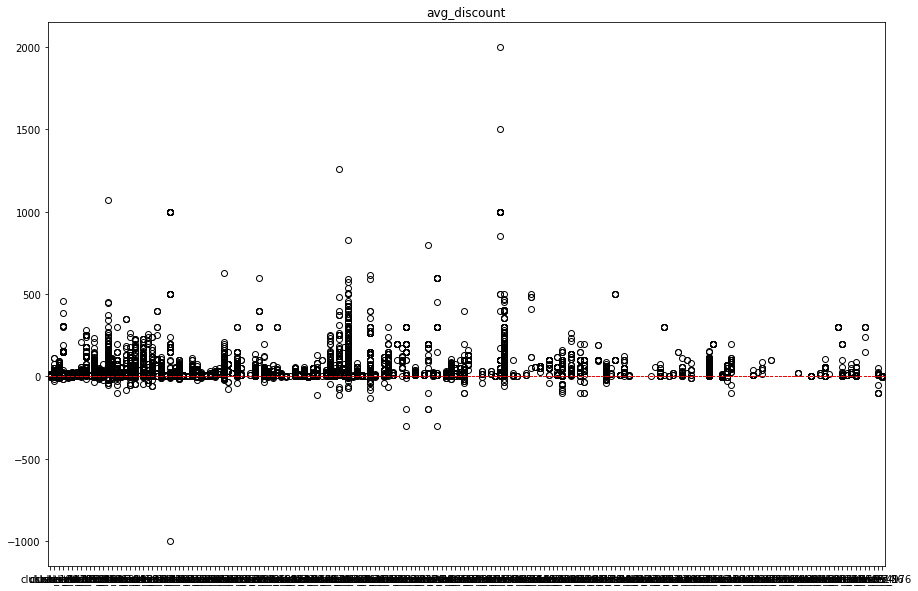

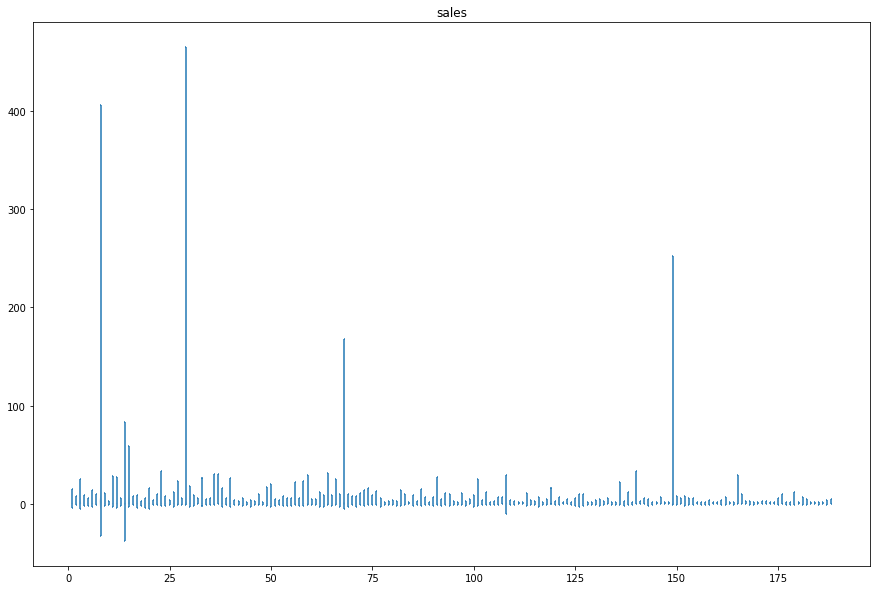

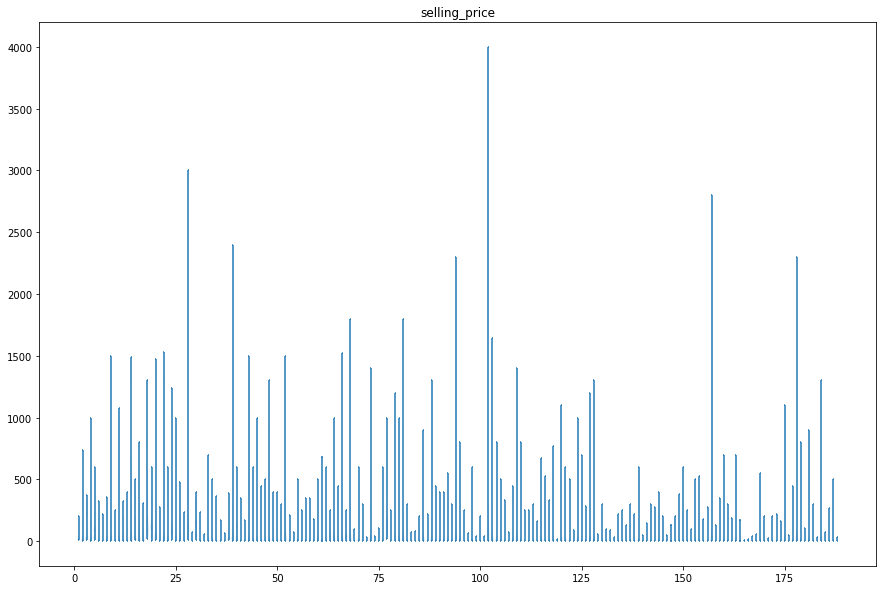

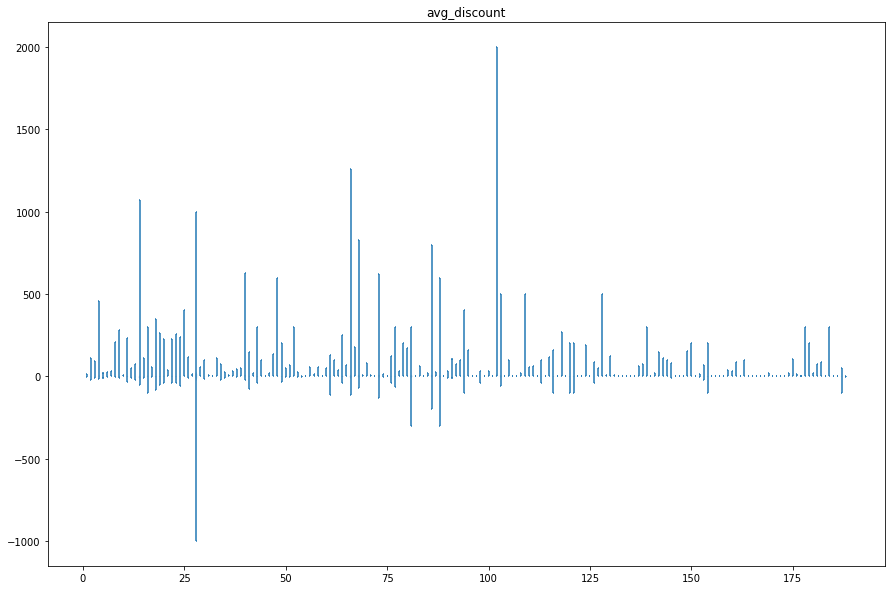



 sku_department


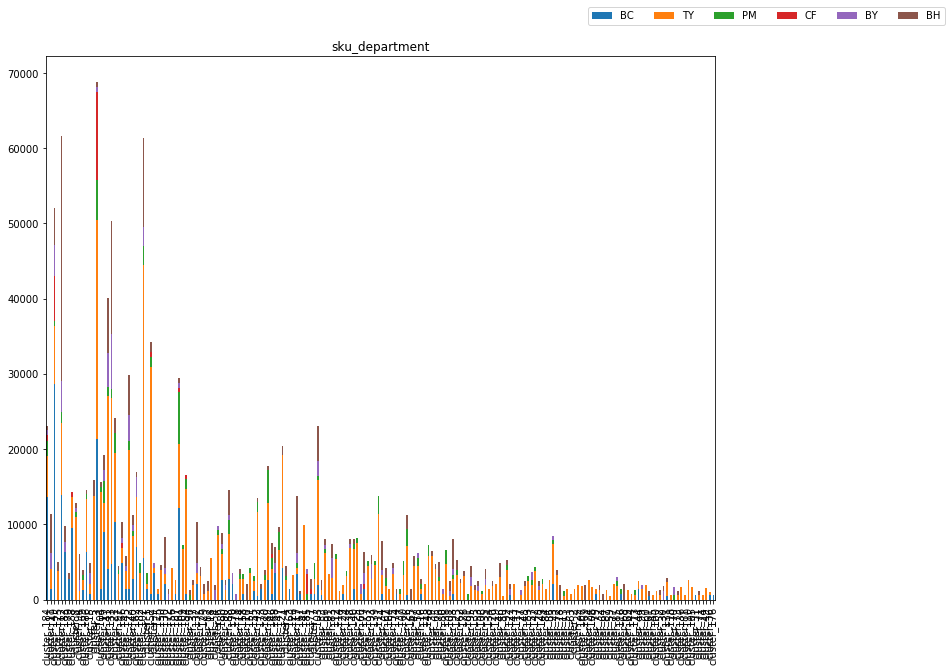



 sku_subdepartment


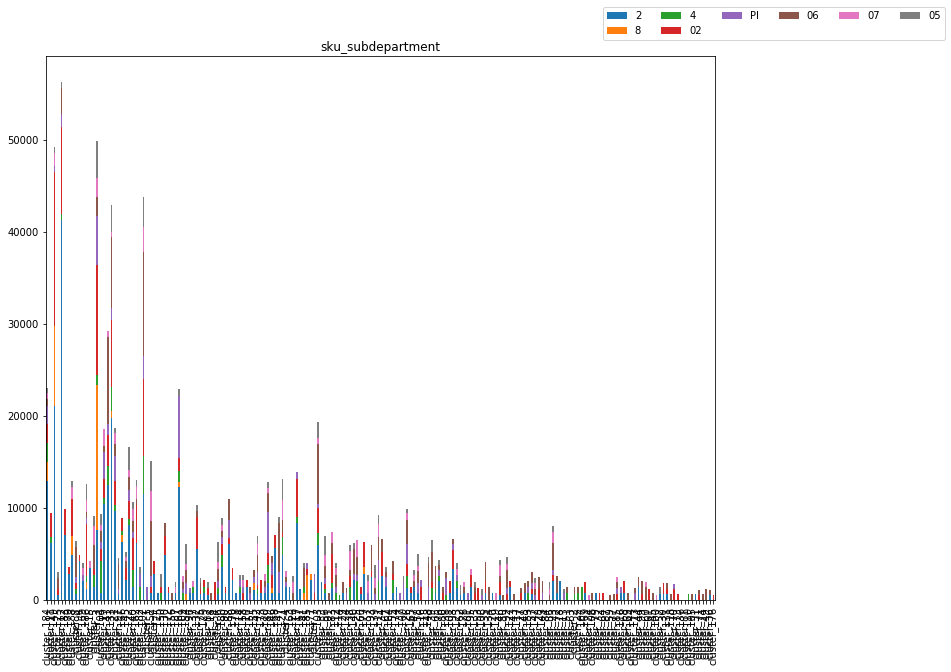



 sku_category


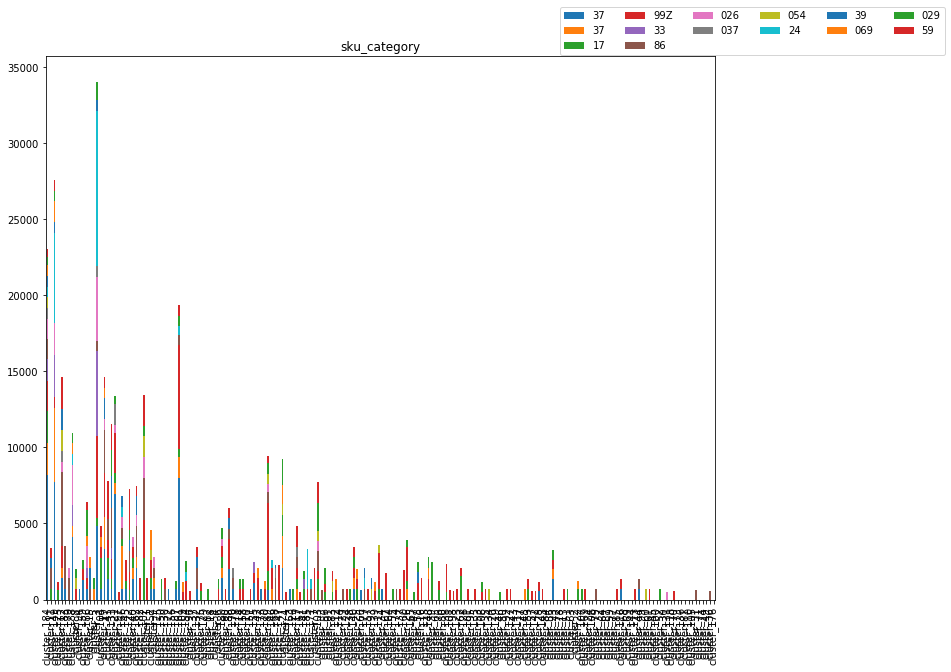



 sku_subcategory


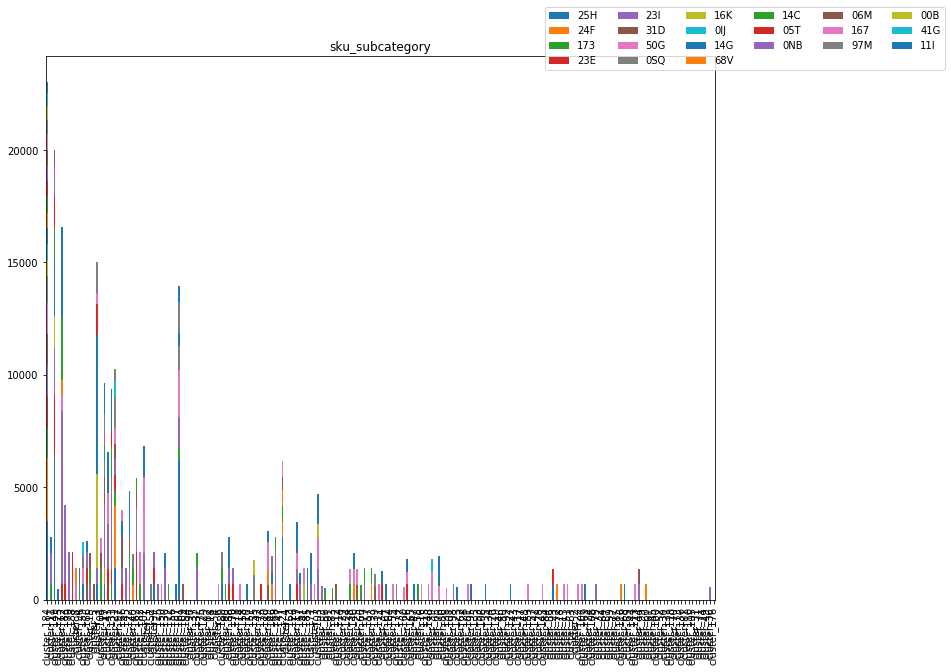

In [37]:
analyze_dtw.plot_cluster_continuous(df_dict, run_cont, colors, True)
analyze_dtw.plot_cluster_continuous_box(df_dict, run_cont, True)
analyze_dtw.plot_cluster_continuous_violin(df_dict, run_cont, True)
analyze_dtw.plot_cluster_categorical(df_dict, run_cats, True)

In [42]:
len(skus)

3193

In [38]:
som_clus.merge(tsne_clus, on='sku_key')

,sku_key,cluster_x,cluster_y
0,28,2,1
1,34,2,6
2,100,4,4
3,152,2,3
4,182,4,5
5,325,3,4
6,521,2,3
7,523,3,4
8,527,3,0
9,585,3,2
